In [28]:
using Sunny
using GLMakie

# SU(3) Case Study: FeI$_{2}$

In this tutorial, we will walk through the process of calculating the dynamical properties of the compound FeI$_2$. This is an effective spin 1 material with a strong single-ion anisotropy, making it an excellent candidate for treatment with generalized SU(3) spin dynamics.  Full details about the model can be found in reference [1].

## Setting up the Crystal

Sunny has a number of facilities for specifying a crystal. Some commonly used crystals are available directly from Sunny. For example, the function `Sunny.fcc_crystal()` will directly return a face-centered cubic crystal:

In [5]:
fcc_cryst = Sunny.fcc_crystal()

Crystal
HM symbol 'F m -3 m' (225)
Lattice params a=1, b=1, c=1, α=90°, β=90°, γ=90°
Cell volume 1
Wyckoff 4a (point group 'm-3m'):
   1. [0, 0, 0]
   2. [0.5, 0.5, 0]
   3. [0.5, 0, 0.5]
   4. [0, 0.5, 0.5]


Note that Sunny provides a complete specification for the crystal it has generated. In particular, it provides the name and space group number, `'F m -3 m' (225)`, the lattice parameters, as well as the location of four ion sites within a unit cell, given in terms of fractional coordinates. 

Going in the other direction, if we know the space group, lattice parameters, and ion locations, we can use this information to construct a crystal. The supplementary information to reference [1] gives the following information about FeI$_2$:

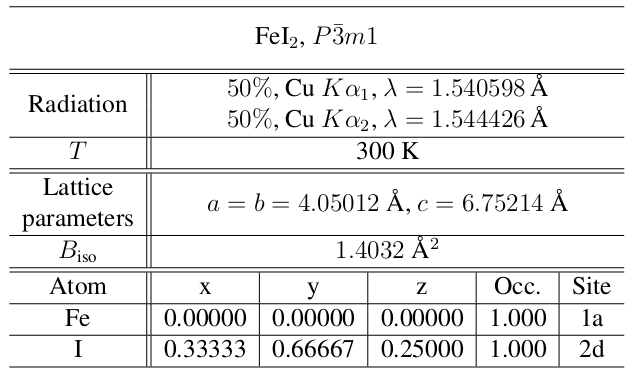

We see that the space group is $P\bar{3}m1$. A quick Google search [reveals](http://img.chem.ucl.ac.uk/sgp/large/156az1.htm) that this corresponds to space group 156. We now can completely specify the FeI$_2$ crystal. (Note that, for this example, we will only be concerned with the Fe ions.)

In [10]:
# Crystal parameters, copied directly from table
space_group = 164
a = b = 4.05012  # angstroms
c = 6.75214
lat_vecs = lattice_vectors(a, b, c, 90, 90, 120)
basis_vecs = [[0,0,0]] # Only considering Fe ion.

# Call `Crystal`, providing lattice vectors, basis vectors, and space group number.
# Note that there are multiple representations of this crystal. The keyword `setting`
# fixes a choice. If this keyword is not provided, Crystal will return all possibilities.
FeI2_cryst = Crystal(lat_vecs, basis_vecs, space_group; setting="1")

Crystal
HM symbol 'P -3 m 1' (164)
Lattice params a=4.05, b=4.05, c=6.752, α=90°, β=90°, γ=120°
Cell volume 95.92
:
   1. [0, 0, 0]


That's all there is to it. We now have an FeI$_2$ crystal. Sunny can now provide automatic symmetry analysis, ensuring that we only specify valid interactions.

## Specifying Interactions

We now wish to implement the various interactions specified in the Hamiltonian given in reference [1]. This includes 6 different anisotropic exchange interactions, as well as a single-ion anisotropy. Each of these interactions must be assigned to a particular bond or particular site of the crystal. Note that it is necessary to specify an interaction only once on a single instance of a symmetry equivalent bond or site.  Sunny will automatically propagate the interaction to all other equivalent bonds or sites.

### Exchange interactions
The different bonds on which we wish to specify exchange interactions are illustrated with yellow arrows in the the following illustration [1]:


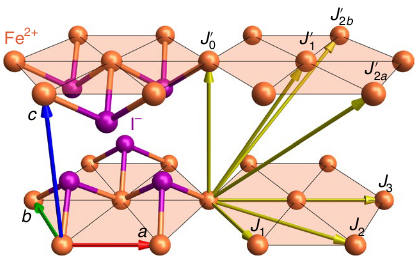

We must take care to map this information correctly onto our crystal in Sunny. One approach is simply to ask Sunny to list all of the possible bonds supported by our crystal structure. This can be achieved with a call to `print_bond_table(crystal, max_dist)`, which will return all bonds within a maximum distance from the origin. 

In [11]:
print_bond_table(FeI2_cryst, 10.0)

Atom 1, position [0, 0, 0], multiplicity 1
Allowed single-ion anisotropy or g-tensor: | A  0  0 |
                                           | 0  A  0 |
                                           | 0  0  B |

Bond(1, 1, [1, 0, 0])
Distance 4.0501, coordination 6
Connects [0, 0, 0] to [1, 0, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  D |
                         | 0  D  C |

Bond(1, 1, [0, 0, 1])
Distance 6.7521, coordination 2
Connects [0, 0, 0] to [0, 0, 1]
Allowed exchange matrix: | A  0  0 |
                         | 0  A  0 |
                         | 0  0  B |

Bond(1, 1, [1, 2, 0])
Distance 7.015, coordination 6
Connects [0, 0, 0] to [1, 2, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  D |
                         | 0  D  C |

Bond(1, 1, [1, 0, 1])
Distance 7.8737, coordination 12
Connects [0, 0, 0] to [1, 0, 1]
Allowed exchange matrix: | A  F  E |
                         | F  B  D |
                         | E  D  C |


Sunny has provided us with a great deal of useful information here, and it is worth dissecting the results.

The precise syntax for specifying a bond is given at the top of each entry, e.g., `Bond(1, 1, [1, 0, 0])`. The first two arguments specify a pair of ions with an implied orientation (_from_ the first ion _to_ the second). The sites of ions are numbered according to the list provide when making a crystal. Since our cyrstal only contains a single site per unit cell, the first two arguments to `Bond` will always be 1. The list provided as the final argument to `Bond` specifies an offset in terms of lattice vectors. So `Bond(1, 1, [1, 0, 0])` refers to the bond between the same ion in two different unit cells, specifically the unit cell that is offset one `a` lattice vector from the origin.

Sunny lists a number of other important pieces of information. The length of the bond is given by `Distance`, which is useful for determining different orders of nearest neighbor. The coordinates of the origin and destination of the bond are given in fractional coordinates. Finally, we should note that Sunny provides the allowed form of any exchange matrix that is assigned to the bond. If you try to give Sunny an exchange matrix that does not match this form, it will not allow you to build your model.

It should also be noted that, at the very top of the list, Sunny provides the allowed form of a g-tensor or quadratic anisotropy for each unique site. Note that anisotropies for generalized SU(N) spins are analyzed and specified differently than they are for traditional Landau-Lifshitz (LL) dipole dynamics. The default information provided in this list refers to LL-type dipole models. For more on this, see The Model Builder's Quick Reference as well as the section below on specifying the anistropy for this model.

It is of course possible to work through this list and establish a correspondence between different bonds and the figure provided above. For example, we can see that `Bond(1, 1, [1, 0, 0])` refers to $J_1$ in the illustration, since it is the shortest in-plane bond in the list. It is helpful to have a visual aid in this process, however, and Sunny provides a crystal viewer tool for this purpose. 

In [12]:
view_crystal(FeI2_cryst, 10.0)

Sunny.CrystalViewer("<!DOCTYPE html>\n<html>\n\n<head>\n  <title>Sunny Visuals</title>\n\n  <meta name=\"viewport\" content=\"width=device-width, initial-scale=1\">\n  <meta charset=\"UTF-8\" />\n</head>\n\n<body style=\"\n    margin: 0;\n    overflow: hidden;\n    text-align: center;\n    font-size: 12px;\n    font-family: Sans-Serif;\n    color: #444;\n\">\n\n<!-- Might want to copy HTML styles from Jupyter notebook cells here:\n    https://jupyterbook.org/en/stable/interactive/interactive.html\n-->\n<style type=\"text/css\">\n    #flex-container-a576c5635b08{\n        display: flex;\n        margin: 10px;\n        min-height: 400px;\n        min-width: 400px;\n        /* max-width: 800px; */\n    }\n    #widget-container-a576c5635b08 {\n        flex: 0.5;\n        background-color: #EEEEEE;\n        max-width: 200px;\n        border: thin solid black;\n    }\n    #widget-container-a576c5635b08:first-child {\n        margin-right: 10px;\n    }\n    #scene-container-a576c5635b08{\n        flex: 1.0;\n        margin-left:0;\n        background:#000000;\n        border: thin solid black;\n        align-self: center;\n    }\n    /* For an alternative approach to this, see https://stackoverflow.com/a/45046955/500314 */\n    #scene-container-a576c5635b08 canvas{\n        height:100% !important;\n        width:100% !important;\n    }\n</style>\n\n<div id=\"flex-container-a576c5635b08\">\n    <div id=\"widget-container-a576c5635b08\">\n        <!-- Widgets inserted here at runtime. -->\n    </div>\n    <div id=\"scene-container-a576c5635b08\">\n        <!-- <canvas> inserted here at runtime. -->\n    </div>\n</div>\n\n<script id=\"data-a576c5635b08\" type=\"application/json\">{\n\"cellTypes\":    [\"type 1\"],\n\"bondColors\":   [\"0xC721DD\",\"0xD14A00\",\"0x008C00\",\"0x007FB1\",\"0xD1AC00\",\"0x870036\",\"0xFF8FA1\"],\n\"bondLabels\":   [\"J0\",\"J1\",\"J2\",\"J3\",\"J4\",\"J5\",\"J5'\"],\n\"bondTypeIds\":  [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]],\n\"bondVecs\":     [[[-2.02506,-3.5075068083754304,0.0],[-4.05012,0.0,0.0],[2.02506,-3.5075068083754304,0.0],[-2.02506,3.5075068083754304,0.0],[4.05012,0.0,0.0],[2.02506,3.5075068083754304,0.0]],[[0.0,0.0,-6.75214],[0.0,0.0,6.75214]],[[-6.07518,-3.5075068083754304,0.0],[0.0,-7.015013616750861,0.0],[-6.07518,3.5075068083754304,0.0],[6.07518,-3.5075068083754304,0.0],[0.0,7.015013616750861,0.0],[6.07518,3.5075068083754304,0.0]],[[-2.02506,-3.5075068083754304,-6.75214],[-2.02506,-3.5075068083754304,6.75214],[-4.05012,0.0,-6.75214],[-4.05012,0.0,6.75214],[2.02506,-3.5075068083754304,-6.75214],[2.02506,-3.5075068083754304,6.75214],[-2.02506,3.5075068083754304,-6.75214],[-2.02506,3.5075068083754304,6.75214],[4.05012,0.0,-6.75214],[4.05012,0.0,6.75214],[2.02506,3.5075068083754304,-6.75214],[2.02506,3.5075068083754304,6.75214]],[[-4.05012,-7.015013616750861,0.0],[-8.10024,0.0,0.0],[4.05012,-7.015013616750861,0.0],[-4.05012,7.015013616750861,0.0],[8.10024,0.0,0.0],[4.05012,7.015013616750861,0.0]],[[-6.07518,-3.5075068083754304,-6.75214],[0.0,-7.015013616750861,6.75214],[-6.07518,3.5075068083754304,6.75214],[6.07518,-3.5075068083754304,-6.75214],[0.0,7.015013616750861,-6.75214],[6.07518,3.5075068083754304,6.75214]],[[-6.07518,-3.5075068083754304,6.75214],[0.0,-7.015013616750861,-6.75214],[-6.07518,3.5075068083754304,-6.75214],[6.07518,-3.5075068083754304,6.75214],[0.0,7.015013616750861,6.75214],[6.07518,3.5075068083754304,-6.75214]]],\n\"lattVecs\":     [[4.05012,0.0,0.0],[-2.02506,3.5075068083754304,0.0],[0.0,0.0,6.75214]],\n\"basisVecs\":    [[0.0,0.0,0.0]],\n\"lattCells\":    [5,5,3],\n\"atomsPerCell\": 1\n}</script>\n\n<!-- Insert either a link to the Javascript file (development mode) or the\nactual Javascript content (production mode). -->\n<script >'use strict';\n\n(async function () {\n    const THREE = await import(\"https://cdn.skypack.dev/three@0.132.2\");\n    const OrbitControls = (await import(\"https://cdn.skypack.dev/three@0.132.2/examples/jsm/controls/OrbitControls.js\")).Orbi

We can interactively rotate the crystal and highlight bonds. By highlighting all the nearest neighbors (`J0` in the convention used by the crystal viewer) we can quickly identify the the planar hexagon given in the illustration from reference [1] and work our way out from there.

(ASIDE: Maybe it would be good if the crystal viewer labels the bonds according to Sunny syntax or offers the option to. A minor point, counts neighbor order starting from 1 (i.e., $J\_1$ is the nearest neighbor), whereas the crystal viewer begins counting from 0. I don't know if there is a standard convention here.)

To create an exchange interaction, one simply calls `exchange(J, bond)`. For example, if we have specified the exchange matrix for the nearest in-plane neighbor, `J1`, we would write: `exch1 = exchange(J1, Bond(1, 1, [1, 0, 0]))`. 

We follow this procedure below, assigning the exchange matrices provided in reference [1] to their corresponding bonds in our crystal. We encourage the reader to go through this exercise independently, but the code below can be executed directly for those who wish just to follow along.

In [15]:
# ---------- Parameters as given in supplementary information ---------- #
J1pm   = -0.236
J1pmpm = -0.161
J1zpm  = -0.261

J2pm   = 0.026

J3pm   = 0.166

J′0pm  = 0.037

J′1pm  = 0.013

J′2apm = 0.068
D      = 2.165

J1zz   = -0.236
J2zz   = 0.113
J3zz   = 0.211
J′0zz  = -0.036
J′1zz  = 0.051
J′2azz = 0.073
J′2bzz = 0.0

# ---------- Parameters transformed into exchange matrices ---------- #
J1xx = J1pm + J1pmpm 
J1yy = J1pm - J1pmpm
J1yz = J1zpm

J₁ = [J1xx  0.0   0.0;
      0.0   J1yy  J1yz;
      0.0   J1yz  J1zz]

J₂ = [J2pm  0.0  0.0;
      0.0   J2pm 0.0;
      0.0   0.0  J2zz]

J₃ = [J3pm   0.0   0.0;
      0.0    J3pm  0.0;
      0.0    0.0   J3zz]

J′₀ = [J′0pm  0.0   0.0;
       0.0    J′0pm 0.0;
       0.0    0.0   J′0zz]

J′₁ = [J′1pm  0.0   0.0;
       0.0    J′1pm 0.0;
       0.0    0.0   J′1zz]

J′₂ = [J′2apm  0.0   0.0;
       0.0    J′2apm 0.0;
       0.0    0.0   J′2azz]


exchange_interactions = [
      exchange(J₁, Bond(1,1,[1,0,0])),
      exchange(J₂, Bond(1,1,[1,2,0])),
      exchange(J₃, Bond(1,1,[2,0,0])),
      exchange(J′₀, Bond(1,1,[0,0,1])),
      exchange(J′₁, Bond(1,1,[1,0,1])),
      exchange(J′₂, Bond(1,1,[1,2,1])),
];

### Onsite Anistropy

In addition to the exchange interactions specified above, the model includes a strong single-ion anisotropy term: $D\left(\hat{S}^z\right)^2$. In SU(N) mode, Sunny allows the user to specify the anisotropy directly in this form, as it would appear in the quantum Hamiltonian. We will be using generalized SU(3) spins, and we can generate the appropriate spin operators (the spin 3/2 representation of SU(2)) by calling Sunny's `gen_spin_ops` functions.

In [18]:
N = 3
S = Sunny.gen_spin_ops(3); # Returns a length 3 vector containing Sˣ, Sʸ and Sᶻ.

We can then specify our anisotropy matrix.

In [21]:
D = -2.165
Sᶻ = S[3]

Λ = D*(Sᶻ)^2;

The anistropy can then be created by a call to `SUN_anisotropy(Λ, site)`, where site again refers to the ordered list of ions in each unit cell. As we have only one site per unit cell, we simply execute the following:

In [22]:
aniso = SUN_anisotropy(Λ, 1);

When we instantiate our model, Sunny will automatically analyze this anisotropy to ensure that it does not violate the symmetry properties of the crystal to which it is assigned.  In this case, we know that the anisotropy is valid and expect Sunny to accept it without complaint. It should be noted, however, that Sunny provides a range of tools for determining the allowed anisotropies supported by any crystal structure. A simple interface to this capability is provided through the function `print_allowed_anisotropy(crystal, i)`, where `i` refers to the site number within a unit cell. This function will return the allowed anisotropies in terms of Stevens operators. See the --- for additional information on these capabilities.

## Building a `SpinSystem`

To tie everything together, we need to build a `SpinSystem`. A `SpinSystem` is created by providing a crystal, a list of interactions, lattice dimensions, and, optionally, a list of `SiteInfo`s. We have already made our crystal and specified our interactions, and we may choose any dimensions we like. `SiteInfo(i; N=0, g=2*I(3), spin_rescaling=1.0)` allows us to specify additional information that applies only to individual ions within the unit cell: `N` determines the dimension of our generalized SU(N) spin; `g` is the g-tensor; and `spin_rescaling` determines and arbitrary rescaling of the spin on the specified site. Note that the default setting of `N=0` corresponds to working with traditional, classical spins, i.e. real, 3-component vectors corresponding to magnetic dipole moments. For this example, we wish to use SU(3) generalized spins and will correspondingly set `N=3`.

In [25]:
site_infos = [SiteInfo(1; N=3)];

After specifying lattice dimensions and assembling our interactions into a single list, we can build our model.

In [26]:
dims = (8, 8, 8)
interactions = [exchange_interactions; aniso]

sys = SpinSystem(FeI2_cryst, interactions, dims, site_infos)

Spin System [SU(3)]
Basis 1, Lattice dimensions (8, 8, 8)


In the process of creating our `SpinSystem`, Sunny rigorously checked the validity of all our interactions. Had we provided any exchange interaction or anisotropy that violated the symmetry properties of our crystal, it would have resulted in an error.

With our `SpinSystem` in hand, we can begin performing calculations. 

## Finding a Ground State

In the remainder of this tutorial, we will go through the basic steps necessary to calculate a dynamical structure factor for FeI$_2$. We note at the outset that Sunny provides some automated functionality for performing such calculations. See the official documentation [here](https://sunnysuite.github.io/Sunny.jl/dev/library/#Sunny.dynamic_structure_factor) and an example [here](https://sunnysuite.github.io/Sunny.jl/dev/examples/#Example-1:-Diamond-lattice-with-antiferromagnetic-Heisenberg-interactions). Many materials require more specialized procedures for finding ground states, however. We hope that by presenting a slightly more bare-bones approach, readers will be better equipped to build their own specialized computational tools on top of the Sunny platform.

It is possible to formulate an Langevin equation from the classical SU(N) dynamics supported by Sunny, i.e., to perform dynamical simulations in the presence of a thermal bath. This is a very efficient approach to sampling states at finite temperatures and is one of Sunny's most powerful features. At low temperatures, however, updates are very local, determined primarily by the deterministic part of the dynamics. This can be a problem for some models. In particular, FeI$_2$ has a strong anistropy which gives the spins an Ising-like character. It will thus be useful to also use a traditional Metroplis sampling approach which uses spin flips for proposed udpates.

### Langevin Sampler

To set up a 

### Ising Sampler

## Calculating a Dynamical Structure Factor

## References
[1] Bai et al., _Hybridized quadrupolar excitations in the spin-anisotropic frustrated magnet FeI2_, Nature Physics v. 17 (2021). (https://doi.org/10.1038/s41567-020-01110-1)